# FXa protein: Conformations Metadata
## Data load and preprocessing

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [23]:
%run ./1_Helper_functions.ipynb

## Load the data
### Ensemble docking scores

In [24]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.05


### Protein conformations metadata

In [25]:
path_to_file = '../../../FXa/ANALISIS/1_Fetching_and_generating_data/TABLA_MTDATA_FXA_136_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

#### Protein volume

In [26]:
# Volume using povme
# Get it manually to include SASA
df_pocket = pd.read_csv('../../../FXa/FILES/CRYSTALS/TRAJ_CRYSTALS_PDB/povme/FXA_POCKET_RES_align/res_output.txt', sep='|', 
            skiprows=312, header=None, skipfooter=3, engine='python',
            names=['pdb_id', 'volumen', 'surf_area'], index_col=0)

# Include it to the final table
df_pocket.index = df_prot.index
# merge both
df_pocket = df_prot.merge(df_pocket, how='inner', left_index=True, right_index=True)

#### Apo or holo conformation
Only with respect to the defined pocket

In [27]:
df_pocket['Apo'] = ['holo' if i > 0 else 'apo' for i in df_pocket.NumLigs] 

# How many of each are there?
df_pocket['Apo'].value_counts()

holo    134
apo       2
Name: Apo, dtype: int64

#### If the protein is bound to other proteic entities 

In [28]:
df_pocket['Single Entity'] = ['bound' if i > 1 else 'single' for i in df_pocket.Entities] 

#### Fill Inhibitor mass column with 0s

In [29]:
df_pocket['Inhib_mass'] = pd.to_numeric(df_pocket['Inhib_mass']).fillna(0)

#### Fill Resolution values, if needed

In [30]:
df_pocket['Resolution'] = pd.to_numeric(df_pocket['Resolution']).fillna(0)

#### Get the performance measures and append them

In [31]:
# AUC ROC
metric_params = {'metric_name': 'roc_auc'}
roc_auc = PlotMetric(y, X_merged_dksc.to_dict('list'),
                decreasing=True).format_metric_results(rounded=5, **metric_params)

# Enrichment Factor Ra=12
metric_params = {'metric_name': 'ef', 'fraction': 0.12, 'method':'normalized'}
nef_012 = PlotMetric(y, X_merged_dksc.to_dict('list'),
                decreasing=True).format_metric_results(rounded=5, **metric_params)

# Merge all dataframes
df_merged = df_pocket.join([roc_auc, nef_012], how='inner')

### Keep and rename important columns

In [32]:
# Rename some columns
last_vars = ['Resolution', 'Inhib_mass', 'volumen', 'surf_area', 'Apo', 'Single Entity', 'ROC AUC', 'EF']
new_names = ['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo', 'Single Entity', 'AUC-ROC', 'NEF']
df_final = df_merged[last_vars].rename(columns=dict(zip(last_vars, new_names)))
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

In [33]:
# Save the dataframe
@run_or_load
def save_df(filename, df):
    return df

# Save it
df_final = save_df(f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl', df_final)

File loaded: ./TABLE_Confs_Features_and_performances_fxa.pkl


# Correlations

In [34]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def calculate_pvalues(df, func=spearmanr):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[1], 4)
    return pvalues

def corrfunc(x, y, func=spearmanr, **kws):
    r, _ = func(x, y)
    ax = plt.gca()
    ax.annotate(r"$\rho$ = {:.2f}".format(r), fontsize=14,
                xy=(.1, .9), xycoords=ax.transAxes)

In [35]:
df_final.columns

Index(['Resolution', 'Inhib. MW', 'Pk. Volume', 'Pk. Surf. Area', 'Apo',
       'Single Entity', 'AUC-ROC', 'NEF'],
      dtype='object')

In [36]:
display(df_final.corr(method='spearman'))
display(calculate_pvalues(df_final))

,Resolution,Inhib. MW,Pk. Volume,Pk. Surf. Area,AUC-ROC,NEF
Resolution,1.000000,0.035475,0.228634,0.254285,-0.005835,-0.016075
Inhib. MW,0.035475,1.000000,0.064848,0.194118,0.076359,0.250383
Pk. Volume,0.228634,0.064848,1.000000,0.498993,0.050262,-0.131936
Pk. Surf. Area,0.254285,0.194118,0.498993,1.000000,-0.130039,-0.046060
AUC-ROC,-0.005835,0.076359,0.050262,-0.130039,1.000000,0.632055
NEF,-0.016075,0.250383,-0.131936,-0.046060,0.632055,1.000000


,Resolution,Inhib. MW,Pk. Volume,Pk. Surf. Area,AUC-ROC,NEF
Resolution,0,0.6818,0.0074,0.0028,0.9462,0.8526
Inhib. MW,0.6818,0,0.4532,0.0235,0.3769,0.0033
Pk. Volume,0.0074,0.4532,0,0,0.5612,0.1257
Pk. Surf. Area,0.0028,0.0235,0,0,0.1313,0.5944
AUC-ROC,0.9462,0.3769,0.5612,0.1313,0,0
NEF,0.8526,0.0033,0.1257,0.5944,0,0


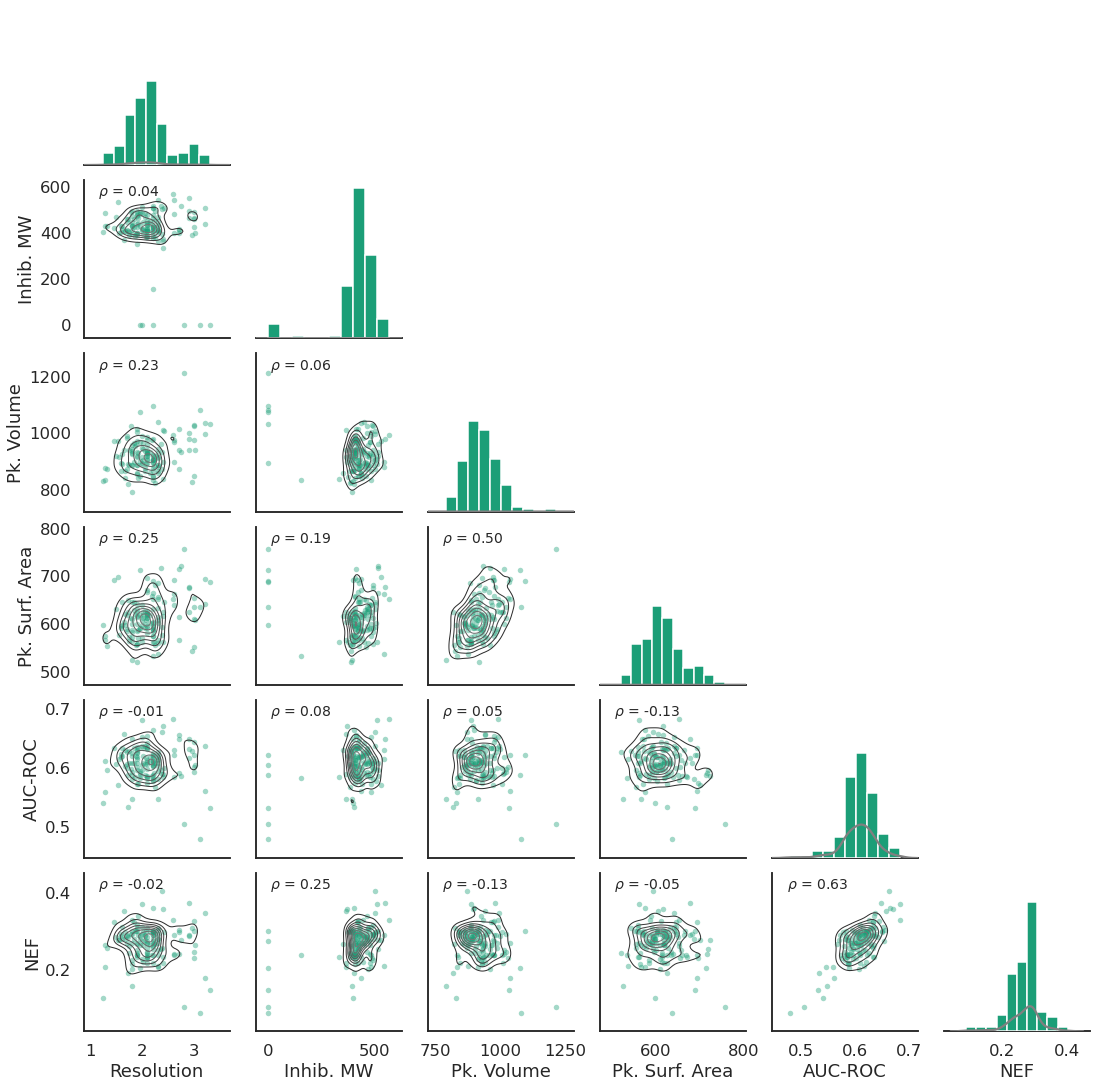

In [37]:
g = sns.pairplot(df_final, diag_kind="hist", corner=True,  
                 plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k', 'linewidth': 0})
g.map_lower(sns.kdeplot, levels=8, color=".5", linewidths=1)
g.map_diag(sns.kdeplot, color='.5')
g.map_lower(corrfunc)
plt.show()

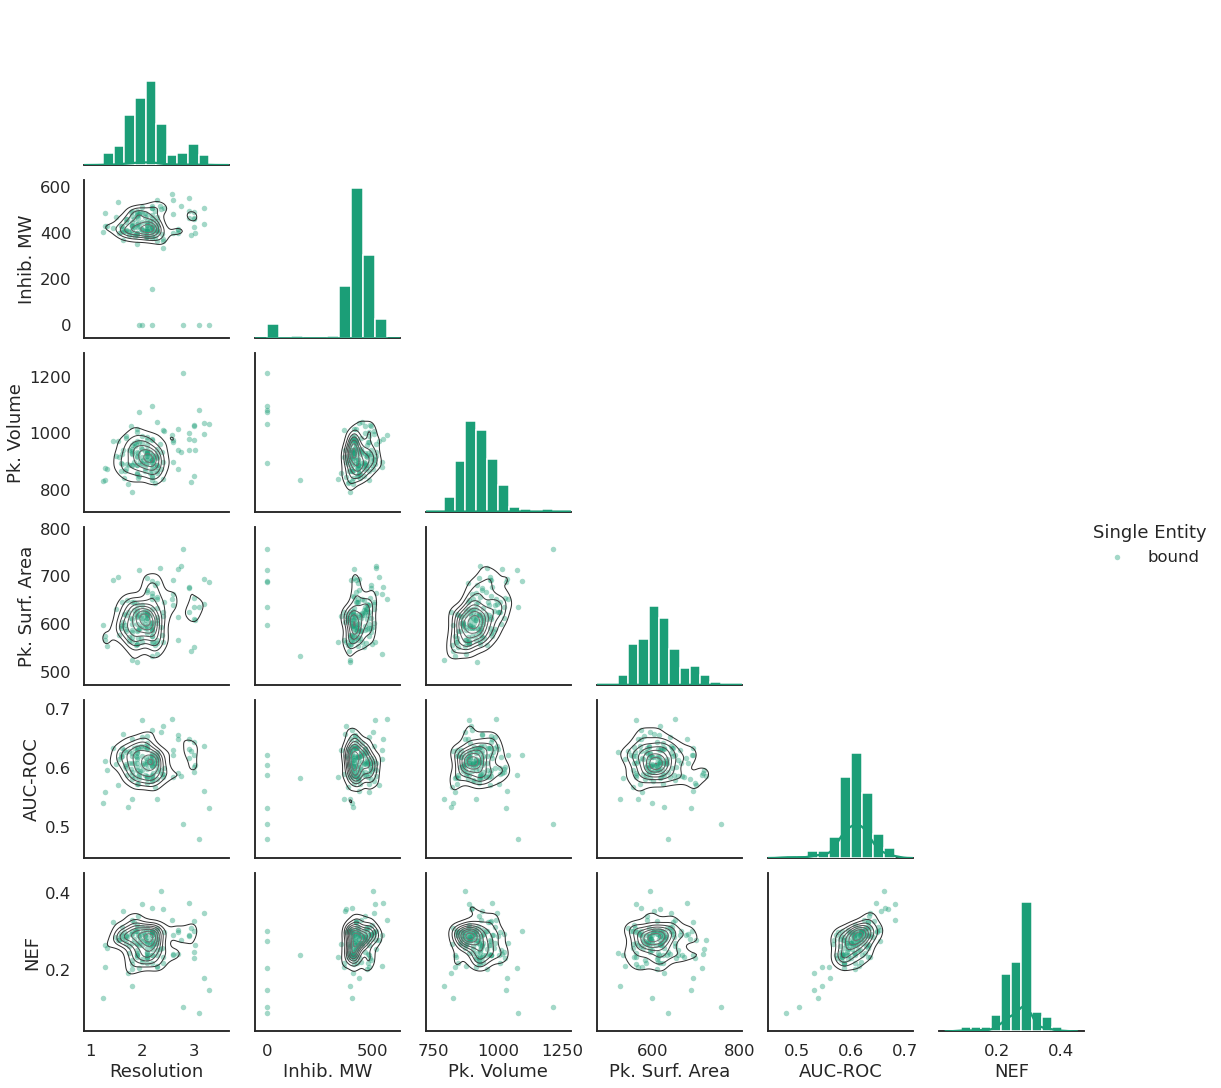

In [38]:
g = sns.pairplot(df_final, diag_kind="hist", corner=True, hue='Single Entity',
                 plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k', 'linewidth': 0})
g.map_lower(sns.kdeplot, levels=8, color=".5", linewidths=1)
g.map_diag(sns.kdeplot)
# g.map_lower(corrfunc)
plt.show()